# Blue Sky Run Engine

Contents:

* The Run Engine processes messages
* There is two-way communication between the message generator and the Run Engine
* Control timing with 'sleep' and 'wait'
* Runs can be aborted
* Any functions can subscribe to the live data stream (e.g., live plotting)
* Example: Live Plotting

In [1]:
%run bs.py

motor = Mover('motor', ['pos'])
det = SynGauss('sg', motor, 'pos', center=0, Imax=1, sigma=1)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## The Run Engine processes messages

A message has four parts: a command string, an object, a tuple of positional arguments, and a dictionary of keyword arguments.

In [2]:
Msg('set', motor, {'pos': 5})

set: (mover: motor), ({'pos': 5},), {}

In [3]:
Msg('trigger', motor)

trigger: (mover: motor), (), {}

In [4]:
Msg('read', motor)

read: (mover: motor), (), {}

In [5]:
RE = RunEngine()

In [45]:
def simple_scan(motor):
    "Set, trigger, read"
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('read', motor)
    
RE.run(simple_scan(motor))

*** Emitted RunStart:
{'beamline_id': 'test', 'uid': '549e8e0b-cd66-45d8-b44c-7045b64308d0', 'time': 1433011278.129966, 'scan_id': 123, 'owner': 'tester'}
set: (mover: motor), ({'pos': 5},), {}
   ret: None
trigger: (mover: motor), (), {}
   ret: None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433011278.439633, 'value': 5}}
*** Emitted RunStop:
{'reason': '', 'time': 1433011278.645251, 'run_start': '549e8e0b-cd66-45d8-b44c-7045b64308d0', 'exit_status': 'success'}


Moving a motor and reading it back is boring. Let's add a detector.

In [7]:
def simple_scan2(motor, det):
    "Set, trigger motor, trigger detector, read"
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('trigger', det)
    yield Msg('read', det)
    
RE.run(simple_scan2(motor, det))

*** Emitted RunStart:
{'beamline_id': 'test', 'uid': '5448cc9d-481e-49eb-a19c-6b6244e11953', 'time': 1433009980.38547, 'scan_id': 123, 'owner': 'tester'}
set: (mover: motor), ({'pos': 5},), {}
   ret: None
trigger: (mover: motor), (), {}
   ret: None
trigger: (reader: sg), (), {}
   ret: None
read: (reader: sg), (), {}
   ret: {'intensity': {'timetamp': 1433009980.800412, 'value': 3.7266531720786709e-06}}
*** Emitted RunStop:
{'reason': '', 'time': 1433009981.004707, 'run_start': '5448cc9d-481e-49eb-a19c-6b6244e11953', 'exit_status': 'success'}


## There is two-way communication between the message generator and the Run Engine

Above we the three messages with the responses they generated from the RunEngine. We can use these responses to make our scan adaptive.

In [8]:
def adaptive_scan(motor, det, threshold):
    """Set, trigger, read until the detector reads intensity < threshold"""
    i = 0
    while True:
        print("LOOP %d" % i)
        yield Msg('set', motor, {'pos': i})
        yield Msg('trigger', motor)
        yield Msg('trigger', det)
        reading = yield Msg('read', det)
        if reading['intensity']['value'] < threshold:
            print('DONE')
            break
        i += 1

RE.run(adaptive_scan(motor, det, 0.2))

*** Emitted RunStart:
{'beamline_id': 'test', 'uid': '094fe05c-3f68-4dab-99a6-ecc48c105ac2', 'time': 1433009982.447273, 'scan_id': 123, 'owner': 'tester'}
LOOP 0
set: (mover: motor), ({'pos': 0},), {}
   ret: None
trigger: (mover: motor), (), {}
   ret: None
trigger: (reader: sg), (), {}
   ret: None
read: (reader: sg), (), {}
   ret: {'intensity': {'timetamp': 1433009982.855087, 'value': 1.0}}
LOOP 1
set: (mover: motor), ({'pos': 1},), {}
   ret: None
trigger: (mover: motor), (), {}
   ret: None
trigger: (reader: sg), (), {}
   ret: None
read: (reader: sg), (), {}
   ret: {'intensity': {'timetamp': 1433009983.367687, 'value': 0.60653065971263342}}
LOOP 2
set: (mover: motor), ({'pos': 2},), {}
   ret: None
trigger: (mover: motor), (), {}
   ret: None
trigger: (reader: sg), (), {}
   ret: None
read: (reader: sg), (), {}
   ret: {'intensity': {'timetamp': 1433009983.879607, 'value': 0.1353352832366127}}
DONE
*** Emitted RunStop:
{'reason': '', 'time': 1433009984.085332, 'run_start': '094

## Control timing with 'sleep' and 'wait'

The 'sleep' command is as simple as it sounds.

In [9]:
def sleepy_scan(motor, det):
    "Set, trigger motor, sleep for a fixed time, trigger detector, read"
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('sleep', None, 2)  # units: seconds
    yield Msg('trigger', det)
    yield Msg('read', det)
    
RE.run(sleepy_scan(motor, det))

*** Emitted RunStart:
{'beamline_id': 'test', 'uid': '70fa15cc-8379-40d4-9f62-901b32be382c', 'time': 1433009985.563407, 'scan_id': 123, 'owner': 'tester'}
set: (mover: motor), ({'pos': 5},), {}
   ret: None
trigger: (mover: motor), (), {}
   ret: None
sleep: (None), (2,), {}
   ret: None
trigger: (reader: sg), (), {}
   ret: None
read: (reader: sg), (), {}
   ret: {'intensity': {'timetamp': 1433009988.08861, 'value': 3.7266531720786709e-06}}
*** Emitted RunStop:
{'reason': '', 'time': 1433009988.295305, 'run_start': '70fa15cc-8379-40d4-9f62-901b32be382c', 'exit_status': 'success'}


The 'wait' command is more powerful. It watches for Movers (e.g., `motor`) to report being done.

### Wait for one motor to be done moving

In [53]:
def wait_one(motor, det):
    "Set, trigger, read"
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor, block_group='A')  # Add motor to group 'A'.
    yield Msg('wait', None, 'A')  # Wait for everything in group 'A' to report done.
    yield Msg('trigger', det)
    yield Msg('read', det)
    
RE.run(wait_one(motor, det))

*** Emitted RunStart:
{'beamline_id': 'test', 'uid': '21386be5-e20e-4217-9ece-0db5a3a82949', 'scan_id': 123, 'time': 1433008818.189182, 'owner': 'tester'}
set: (mover: motor), ({'pos': 5},), {}
   ret: None
trigger: (mover: motor), (), {'block_group': 'A'}
   ret: None
wait: (None), ('A',), {}
   ret: {mover: motor}
trigger: (reader: sg), (), {}
   ret: None
read: (reader: sg), (), {}
   ret: {'intensity': {'value': 3.7266531720786709e-06, 'timetamp': 1433008818.703617}}
*** Emitted RunStop:
{'exit_status': 'success', 'run_start': '21386be5-e20e-4217-9ece-0db5a3a82949', 'reason': '', 'time': 1433008818.909774}


Notice, in the log, that the response to `wait` is the set of Movers the scan was waiting on.

### Wait for two motors to both be done moving

In [54]:
def wait_multiple(motors, det):
    "Set motors, trigger all motors, wait for all motors to move."
    for motor in motors:
        yield Msg('set', motor, {'pos': 5})
        yield Msg('trigger', motor, block_group='A')  # Trigger each motor and add it to group 'A'.
    yield Msg('wait', None, 'A')  # Wait for everything in group 'A' to report done.
    yield Msg('trigger', det)
    yield Msg('read', det)

motor1 = Mover('motor1', ['pos'])
motor2 = Mover('motor2', ['pos'])

RE.run(wait_multiple([motor1, motor2], det))

*** Emitted RunStart:
{'beamline_id': 'test', 'uid': '9a8dbfa3-511d-4e63-8391-b576ca7005c5', 'scan_id': 123, 'time': 1433008819.679768, 'owner': 'tester'}
set: (mover: motor1), ({'pos': 5},), {}
   ret: None
trigger: (mover: motor1), (), {'block_group': 'A'}
   ret: None
set: (mover: motor2), ({'pos': 5},), {}
   ret: None
trigger: (mover: motor2), (), {'block_group': 'A'}
   ret: None
wait: (None), ('A',), {}
   ret: {mover: motor2, mover: motor1}
trigger: (reader: sg), (), {}
   ret: None
read: (reader: sg), (), {}
   ret: {'intensity': {'value': 3.7266531720786709e-06, 'timetamp': 1433008820.499757}}
*** Emitted RunStop:
{'exit_status': 'success', 'run_start': '9a8dbfa3-511d-4e63-8391-b576ca7005c5', 'reason': '', 'time': 1433008820.708166}


### Advanced Example: Wait for different groups of motors at different points in the run

If the `'A'` bit seems pointless, the payoff is here. We trigger all the motors at once, wait for the first two, read, wait for the last one, and read again. This is merely meant to show that complex control flow is possible.

In [55]:
def wait_complex(motors, det):
    "Set motors, trigger motors, wait for all motors to move."
    # Same as above...
    for motor in motors[:-1]:
        yield Msg('set', motor, {'pos': 5})
        yield Msg('trigger', motor, block_group='A')
        
    # ...but put the last motor is separate group.
    yield Msg('set', motors[-1], {'pos': 5})
    yield Msg('trigger', motors[-1], block_group='B')
    
    yield Msg('wait', None, 'A')  # Wait for everything in group 'A' to report done.
    yield Msg('trigger', det)
    yield Msg('read', det)
    
    yield Msg('wait', None, 'B')  # Wait for everything in group 'B' to report done.
    yield Msg('trigger', det)
    yield Msg('read', det)
    
motor3 = Mover('motor3', ['pos'])

RE.run(wait_complex([motor1, motor2, motor3], det))

*** Emitted RunStart:
{'beamline_id': 'test', 'uid': '2bfc0b56-c988-4962-8135-bb28a3e08d44', 'scan_id': 123, 'time': 1433008822.63035, 'owner': 'tester'}
set: (mover: motor1), ({'pos': 5},), {}
   ret: None
trigger: (mover: motor1), (), {'block_group': 'A'}
   ret: None
set: (mover: motor2), ({'pos': 5},), {}
   ret: None
trigger: (mover: motor2), (), {'block_group': 'A'}
   ret: None
set: (mover: motor3), ({'pos': 5},), {}
   ret: None
trigger: (mover: motor3), (), {'block_group': 'B'}
   ret: None
wait: (None), ('A',), {}
   ret: {mover: motor2, mover: motor1}
trigger: (reader: sg), (), {}
   ret: None
read: (reader: sg), (), {}
   ret: {'intensity': {'value': 3.7266531720786709e-06, 'timetamp': 1433008823.767201}}
wait: (None), ('B',), {}
   ret: {mover: motor3}
trigger: (reader: sg), (), {}
   ret: None
read: (reader: sg), (), {}
   ret: {'intensity': {'value': 3.7266531720786709e-06, 'timetamp': 1433008824.076329}}
*** Emitted RunStop:
{'exit_status': 'success', 'run_start': '2bfc

## Runs can be aborted

### SIGINT (Ctrl+C) is reliably caught before each message is processed, even across threads.

The output below is truncated because it caught Ctrl+C (or, in the notebook, "Interrupt Kerenel").

In [31]:
RE.run(simple_scan(motor))

*** Emitted RunStart:
{'beamline_id': 'test', 'uid': 'aa014369-c061-48ed-ab95-f266e6feb673', 'time': 1433010934.42001, 'scan_id': 123, 'owner': 'tester'}
*** Emitted RunStop:
{'reason': '', 'time': 1433010934.526744, 'run_start': 'aa014369-c061-48ed-ab95-f266e6feb673', 'exit_status': 'abort'}


Exception in thread Thread-15:
Traceback (most recent call last):
  File "/Users/dallan/miniconda/envs/py3/lib/python3.4/threading.py", line 920, in _bootstrap_inner
    self.run()
  File "/Users/dallan/miniconda/envs/py3/lib/python3.4/threading.py", line 868, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/dallan/Documents/Repos/bluesky/bs.py", line 290, in <lambda>
    func = lambda: self.run_engine(gen)
  File "/Users/dallan/Documents/Repos/bluesky/bs.py", line 322, in run_engine
    raise RunInterrupt("RunEngine detected a SIGINT (Ctrl+C) "
RunInterrupt: RunEngine detected a SIGINT (Ctrl+C) and aborted the scan. Records were created, but the run was marked with exit_status='abort'.



### Threading is optional -- switch it off for easier debugging

Again, we'll interrupt the scan. We get exactly the same result, but this time we see a full Traceback.

In [57]:
RE.run(simple_scan(motor), use_threading=False)

*** Emitted RunStart:
{'beamline_id': 'test', 'uid': '7c9068f0-707f-4177-8508-27fa4921ac6f', 'scan_id': 123, 'time': 1433008841.624896, 'owner': 'tester'}
set: (mover: motor), ({'pos': 5},), {}
   ret: None
trigger: (mover: motor), (), {}
   ret: None
*** Emitted RunStop:
{'exit_status': 'abort', 'run_start': '7c9068f0-707f-4177-8508-27fa4921ac6f', 'reason': '', 'time': 1433008841.947767}


RunInterrupt: RunEngine detected a SIGINT (Ctrl+C) and aborted the scan. Records were created, but the run was marked with exit_status='abort'.

## Any functions can subscribe to the live data stream (e.g., live plotting)

In the examples above, the runs have been emitting RunStart and RunStop Documents, but no Events or Event Descriptors. We will add those now.

### Emitting Events and Event Descriptors

The `'create'` and `'save'` commands collect all the reads between them into one Event.

If that particular set of objects has never been bundled into an Event during this run, then an Event Descriptor is also created.

All four Documents -- RunStart, RunStop, Event, and EventDescriptor -- are simply Python dictionaries.

In [24]:
def simple_scan_saving(motor):
    "Set, trigger, read"
    yield Msg('create')
    yield Msg('set', motor, {'pos': 5})
    yield Msg('trigger', motor)
    yield Msg('read', motor)
    yield Msg('save')
    
RE.run(simple_scan_saving(motor))

*** Emitted RunStart:
{'beamline_id': 'test', 'owner': 'tester', 'uid': '1eaeb364-15ac-4b80-afe0-35a3eaa3c1c7', 'time': 1433011817.137248, 'scan_id': 123}
create: (None), (), {}
   ret: None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
trigger: (mover: motor), (), {}
   ret: None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433011817.548762, 'value': 5}}
*** Emitted Event Descriptor:
{'data_keys': {'pos': {'source': 'motor', 'dtype': 'number'}}, 'run_start': '1eaeb364-15ac-4b80-afe0-35a3eaa3c1c7', 'time': 1433011817.758388, 'uid': '13718b0a-d3b9-4397-9d17-26ea5a413ba3'}
*** Emitted Event:
{'seq_num': 1, 'data': {'pos': {'timestamp': 1433011817.548762, 'value': 5}}, 'uid': '1a084d79-fdbe-4bc4-b177-7ef83be7ee6f', 'time': 1433011817.758621, 'descriptor': '13718b0a-d3b9-4397-9d17-26ea5a413ba3'}
save: (None), (), {}
   ret: None
*** Emitted RunStop:
{'exit_status': 'success', 'run_start': '1eaeb364-15ac-4b80-afe0-35a3eaa3c1c7', 'time': 1433011817.86201, 'reason': ''}


### Very Simple Example

Any user function that accepts a Python dictionary can be registered as a "consumer" of these Event Documents. Here's a toy example.

In [7]:
def print_event_time(doc):
    print('===== EVENT TIME:', doc['time'], '=====')

To use this consumer function during a run:

In [8]:
RE.run(simple_scan_saving(motor, det), subscriptions={'event': print_event_time})

*** Emitted RunStart:
{'beamline_id': 'test', 'owner': 'tester', 'uid': '5cbcd69e-8df8-4a82-a449-26d59c3de2f5', 'time': 1433011558.946144, 'scan_id': 123}
create: (None), (), {}
   ret: None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
trigger: (mover: motor), (), {}
   ret: None
trigger: (reader: sg), (), {}
   ret: None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433011559.35857, 'value': 5}}
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433011559.463416, 'value': 3.7266531720786709e-06}}
*** Emitted Event Descriptor:
{'data_keys': {'I': {'source': 'sg', 'dtype': 'number'}, 'pos': {'source': 'motor', 'dtype': 'number'}}, 'run_start': '5cbcd69e-8df8-4a82-a449-26d59c3de2f5', 'time': 1433011559.774423, 'uid': '03001ca5-a857-4ce6-9e46-b0b8fd649233'}
*** Emitted Event:
{'seq_num': 1, 'data': {'intensity': {'timestamp': 1433011559.463416, 'value': 3.726653172078671e-06}, 'pos': {'timestamp': 1433011559.35857, 'value': 5}}, 'uid': '969c301c-f214-456f

The use it by default on every run for this instance of the Run Engine:

In [9]:
token = RE.subscribe('event', print_event_time)
token

1

The output `token`, an integer, can be use to unsubscribe later.

In [10]:
RE.unsubscribe(token)

### Live Plotting

First, we'll create some axes. The code below updates the plot while the run is ongoing.

<IPython.core.display.Javascript object>


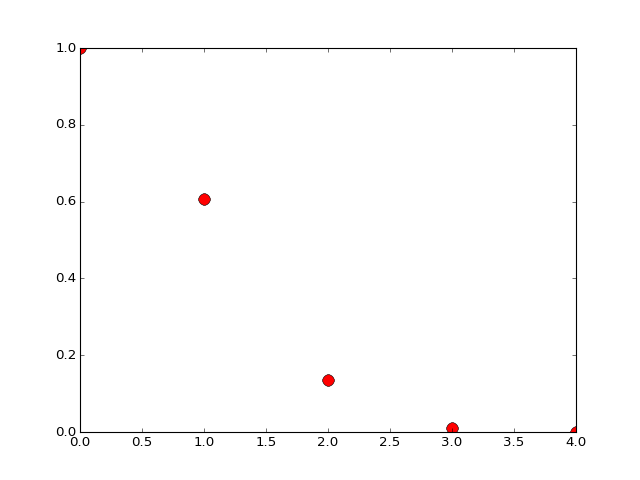

In [37]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

In [38]:
def stepscan(motor, detector):
    for i in range(5):
        yield Msg('create')
        yield Msg('set', motor, {'pos': i})
        yield Msg('trigger', motor)
        yield Msg('trigger', det)
        yield Msg('read', motor)
        yield Msg('read', detector)
        yield Msg('save')

def live_scalar_plotter(ax, y, x):
    x_data, y_data = [], []
    line, = ax.plot([], [], 'ro', markersize=10)
    def update_plot(doc):
        # Update with the latest data.
        x_data.append(doc['data'][x]['value'])
        y_data.append(doc['data'][y]['value'])
        line.set_data(x_data, y_data)
        # Rescale and redraw.
        ax.relim(visible_only=True)
        ax.autoscale_view(tight=True)
        ax.figure.canvas.draw()
    return update_plot

# Point the function to our axes above, and specify what to plot.
my_plotter = live_scalar_plotter(ax, 'intensity', 'pos')

RE.run(stepscan(motor, det), subscriptions={'event': my_plotter})

*** Emitted RunStart:
{'beamline_id': 'test', 'owner': 'tester', 'uid': '8bd8e8b6-f1aa-481f-9c9c-6777a0837b9e', 'time': 1433012270.758852, 'scan_id': 123}
create: (None), (), {}
   ret: None
set: (mover: motor), ({'pos': 0},), {}
   ret: None
trigger: (mover: motor), (), {}
   ret: None
trigger: (reader: sg), (), {}
   ret: None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433012271.165664, 'value': 0}}
read: (reader: sg), (), {}
   ret: {'intensity': {'timestamp': 1433012271.266142, 'value': 1.0}}
*** Emitted Event Descriptor:
{'data_keys': {'I': {'source': 'sg', 'dtype': 'number'}, 'pos': {'source': 'motor', 'dtype': 'number'}}, 'run_start': '8bd8e8b6-f1aa-481f-9c9c-6777a0837b9e', 'time': 1433012271.579914, 'uid': '96bcac6f-739b-463c-a8e9-a2be46058579'}
*** Emitted Event:
{'seq_num': 1, 'data': {'intensity': {'timestamp': 1433012271.266142, 'value': 1.0}, 'pos': {'timestamp': 1433012271.165664, 'value': 0}}, 'uid': '6775765b-ac06-4107-ba73-1b5c0417b50e', 'time': 143301

### Saving Documents to metadatastore

Mission-critical consumers can be run on the scan thread, where they will block the scan until they return from processing the emitted Documents. This should not be used for computationally heavy tasks like visualization. Its only intended use is for saving data to metadatastore, but users can register any consumers they want, at risk of slowing down the scan.

```
RE._register_scan_callback('event', some_critical_func)
```

The convenience function `register_mds` registers metadatastore's four `insert_*` functions to consume their four respective Documents. These are registered on the scan thread, so data is guaranteed to be saved in metadatastore.

In [18]:
%run register_mds.py

register_mds(RE)

We can verify that this worked by loading this one-point scan from the DataBroker and displaying the data using DataMuxer.

In [19]:
RE.run(simple_scan_saving(motor))

*** Emitted RunStart:
{'beamline_id': 'test', 'uid': '6fdbb66a-cc83-425b-98ee-ca63dcf89f63', 'time': 1433010038.598662, 'scan_id': 123, 'owner': 'tester'}
create: (None), (), {}
   ret: None
set: (mover: motor), ({'pos': 5},), {}
   ret: None
trigger: (mover: motor), (), {}
   ret: None
read: (mover: motor), (), {}
   ret: {'pos': {'timestamp': 1433010039.031538, 'value': 5}}
*** Emitted Event Descriptor:
{'time': 1433010039.236176, 'uid': 'efcf48ca-f499-4ad6-8138-ee4272d4aa76', 'run_start': '6fdbb66a-cc83-425b-98ee-ca63dcf89f63', 'data_keys': {'pos': {'source': 'motor', 'dtype': 'number'}}}
*** Emitted Event:
{'uid': '181409f6-a4bf-4c8a-91b1-1fdbff036956', 'descriptor': 'efcf48ca-f499-4ad6-8138-ee4272d4aa76', 'time': 1433010039.243223, 'data': {'pos': {'timestamp': 1433010039.031538, 'value': 5}}, 'seq_num': 1}
save: (None), (), {}
   ret: None
*** Emitted RunStop:
{'reason': '', 'time': 1433010039.351014, 'run_start': '6fdbb66a-cc83-425b-98ee-ca63dcf89f63', 'exit_status': 'success'}


In [20]:
from dataportal import DataBroker as db

header = db[-1]
header

<Header scan_id=123 run_start_uid='6fdbb66a-cc83-425b-98ee-ca63dcf89f63'>

In [21]:
from dataportal import DataMuxer as dm

dm.from_events(db.fetch_events(header)).to_sparse_dataframe()

,pos,time
0,5,2015-05-30 18:20:39.243223
